In [1]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 911kB 2.8MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [854 kB]
Get:14 http://

In [0]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import requests
import time
import json
import keras
import warnings
import random
import sys
import time
from google.colab import drive
from google.colab.patches import cv2_imshow
from bs4 import BeautifulSoup
from selenium import webdriver
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras import backend as K

# Display preference
warnings.filterwarnings('ignore')

In [3]:
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
def scroll(driver, timeout):
    
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
    
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait
        time.sleep(timeout)

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        
        if new_height == last_height:
            
            break
        
        last_height = new_height   

In [0]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

def all_links(url, action, gender=0):
    
    # Setup driver
    driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)

    # Wait before throwing an exception
    driver.implicitly_wait(20)

    # Open the page
    driver.get(url)
    
    # Start scrolling
    scroll(driver, 10)
    
    # Beautiful Soup parses page_source
    soup = BeautifulSoup(driver.page_source, 'lxml')
    
    # Close the driver
    driver.close()

    if action == 1:
    
        # Empty dictionary to store m from page source
        get_m = {}
    
        # Counter for get_m dictionary
        get_m_counter = 0

        # Looping through all the a elements in the page source
        for link in soup.find_all('a', {'class': 'iusc'}):
    
            # Add values to dictionary
            get_m[get_m_counter] = link.get('m')
        
            # Increment counter
            get_m_counter += 1
        
        # Convert from string to dictionary
        for key, value in get_m.items():
            get_m[key] = json.loads(value)
        
        # Empty list to store image links
        links = []
    
        # Loop through get_m dictionary and add image links to links list
        for value in get_m.values():
            links.append([value['murl'], gender])
        
        return links
    else:
        return soup

In [0]:
# List of names to search
names = []

In [0]:
# Popular names url
name_url = 'https://www.ssa.gov/oact/babynames/decades/century.html'

# Beautiful Soup object
soup_name = all_links(name_url, 0)

# Get td tag
td_tag = soup_name.select('.t-stripe > tbody > tr > td')

# Add name to search names
names += [name.get_text().lower() for name in td_tag if name.get_text().isalpha()]

In [0]:
# List for male names
male_names = []

# List for female names
female_names = []

for index, name in enumerate(names, 0):
    if index % 2 == 0:
        male_names.append([name, 0])
    else:
        female_names.append([name, 1])

In [0]:
# Get image links for each name
def get_links(names):
    
    image_links_name = []
    pre_image_links_count = 0
    post_image_links_count = 0
    
    for index in range(len(names)):
        
        # Update url
        url = 'https://www.bing.com/images/search?q=' + names[index][0] + '&qs=n&form=QBIR&qft=%20filterui%3Alicense-L2_L3_L4_L5_L6_L7%20filterui%3Aface-face&sp=-1&pq=' + names[index][0] + '&sc=8-9&sk=&cvid=8C2D8EC9A35A4948980A61669549C180'    
    
        # Number of image links before
        pre_image_links_count = len(image_links_name)
    
        # Add image links
        image_links_name += all_links(url, 1, names[index][1])
        
        # Number of image links after
        post_image_links_count = len(image_links_name)
        
        # Number of image links associated with name
        print('{} resulted in {} image links'.format(names[index][0], (post_image_links_count - pre_image_links_count)))
        
    return image_links_name

In [0]:
# List for image links
image_links = []

In [0]:
# Add male name image links
image_links += get_links(male_names)

james resulted in 175 image links
john resulted in 175 image links
robert resulted in 175 image links
michael resulted in 175 image links
william resulted in 175 image links
david resulted in 175 image links
richard resulted in 210 image links
joseph resulted in 175 image links
thomas resulted in 175 image links
charles resulted in 175 image links
christopher resulted in 175 image links
daniel resulted in 175 image links
matthew resulted in 175 image links
anthony resulted in 175 image links
donald resulted in 175 image links
mark resulted in 210 image links
paul resulted in 175 image links
steven resulted in 175 image links
andrew resulted in 175 image links
kenneth resulted in 175 image links
joshua resulted in 175 image links
george resulted in 175 image links
kevin resulted in 175 image links
brian resulted in 175 image links
edward resulted in 175 image links
ronald resulted in 175 image links
timothy resulted in 175 image links
jason resulted in 175 image links
jeffrey resulted i

In [0]:
# Add female name image links
image_links += get_links(female_names)

mary resulted in 175 image links
patricia resulted in 175 image links
jennifer resulted in 175 image links
linda resulted in 175 image links
elizabeth resulted in 175 image links
barbara resulted in 175 image links
susan resulted in 175 image links
jessica resulted in 175 image links
sarah resulted in 175 image links
karen resulted in 175 image links
nancy resulted in 175 image links
margaret resulted in 175 image links
lisa resulted in 175 image links
betty resulted in 175 image links
dorothy resulted in 175 image links
sandra resulted in 567 image links
ashley resulted in 175 image links
kimberly resulted in 175 image links
donna resulted in 175 image links
emily resulted in 175 image links
michelle resulted in 175 image links
carol resulted in 175 image links
amanda resulted in 175 image links
melissa resulted in 175 image links
deborah resulted in 175 image links
stephanie resulted in 175 image links
rebecca resulted in 175 image links
laura resulted in 175 image links
sharon resul

In [0]:
print('There are {} image links'.format(len(image_links)))

There are 35774 image links


In [0]:
# Header to accompany get request
headers = {'user-agent': 'scraper - school project (bengriffith@outlook.com)'}

# Counter to be used in image file name
image_counter = 0

# Counter for exceptions occurred
exception_counter = 0

# Write images to disk
for image_link in image_links:
    with open('../gdrive/My Drive/colab/gan/images/face_' + str(image_counter) + '_' + str(image_link[1]) + '.png', 'wb') as f:
        try:
            response = requests.get(image_link[0], headers=headers)
            
            if response.ok:
                f.write(response.content)
        except:
            exception_counter += 1
            continue
    image_counter += 1
    
print('There were {} files removed due to a Request / Response Exception'.format(exception_counter))

There were 76 files removed due to a Request / Response Exception


In [0]:
images_directory = '../gdrive/My Drive/colab/gan/images/'
images_cropped_directory = '../gdrive/My Drive/colab/gan/images_cropped_stage/'
images_cropped_separated = '../gdrive/My Drive/colab/gan/images_cropped_'

In [0]:
# Remove images that create AttributeError
files_removed = 0

for filename in sorted(os.listdir(images_directory))[1:]:
    
    try:
        image = cv2.imread(images_directory + filename)
        (h, w) = image.shape[:2]
    except AttributeError:
        files_removed += 1
        os.remove(images_directory + filename)
        
print('There were {} files removed due to AttributeError'.format(files_removed))

There were 0 files removed due to AttributeError


In [0]:
prototxt = '../gdrive/My Drive/colab/gan/supporting/deploy.prototxt'
model = '../gdrive/My Drive/colab/gan/supporting/res10_300x300_ssd_iter_140000.caffemodel'

In [0]:
file_counter = 0

for filename in sorted(os.listdir(images_directory))[1:]:

    # Image path
    image_path = images_directory + filename
    
    # Load model
    net = cv2.dnn.readNetFromCaffe(prototxt, model)

    # Load image
    image = cv2.imread(image_path)
    (h, w) = image.shape[:2]
    
    # Blob for the image
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # Pass blob through network and retrieve detections / predictions
    net.setInput(blob)
    detections = net.forward()
    
    for i in range(detections.shape[2]):
        
        # Get confidence associated with the prediction
        confidence = detections[0, 0, i, 2]
    
        if confidence > 0.98:
            
            # Coordinates for the bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')
        
            # Coordinates for face
            face = image[startY:endY, startX:endX]
        
            # Save face image 
            cv2.imwrite(images_cropped_directory + filename, face)

            file_counter += 1
        
print('There were {} face images added to images_cropped_stage directory'.format(file_counter))

KeyboardInterrupt: ignored

In [0]:
# List for image data
#image_data = []

# List to store detected face
data = []

# List to store labels
labels = []

In [14]:
for folder in range(1, 7): 

    # Counter
    images_processed = 0

    # Populate image_data list
    for filename in sorted(os.listdir(images_cropped_separated + str(folder) + '/')):
        image_path = images_cropped_separated + str(folder) + '/' + filename
        image = cv2.imread(image_path)
        image = cv2.resize(image, (64, 64))
        image_data.append([image, int(filename[filename.find('.') - 1])])
        images_processed += 1

    print('{} images processed from Folder {}'.format(images_processed, folder))

3682 images processed from Folder 1
4725 images processed from Folder 2
4254 images processed from Folder 3
5566 images processed from Folder 4
4938 images processed from Folder 5
5391 images processed from Folder 6


In [0]:
# Separate image data into data list and labels list
for image in image_data:
    data.append(image[0])
    labels.append(image[1])

In [0]:
# Numpy arrays
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)

In [0]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20)

In [72]:
print('There are {} records in the train dataset'.format(X_train.shape[0]))
print('There are {} records in the test dataset'.format(X_test.shape[0]))

There are 22844 records in the train dataset
There are 5712 records in the test dataset


In [0]:
def model(height, width, depth, num_classes):
    model = Sequential()
    input_shape = (height, width, depth)
    channel_dimension = -1
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model

In [0]:
epochs = 15
batch_size = 32
image_dimensions = (64, 64, 3)

In [0]:
gender_model = model(image_dimensions[0], image_dimensions[1], image_dimensions[2], 1)

In [0]:
gender_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [77]:
gender = gender_model.fit(X_train, y_train, batch_size=batch_size, 
                          validation_data=(X_test, y_test), 
                          epochs=epochs, 
                          verbose=1)

Train on 22844 samples, validate on 5712 samples
Epoch 1/15
22844/22844 [==============================] - 243s 11ms/step - loss: 0.4131 - accuracy: 0.8219 - val_loss: 0.3124 - val_accuracy: 0.8762
Epoch 2/15
22844/22844 [==============================] - 244s 11ms/step - loss: 0.3126 - accuracy: 0.8801 - val_loss: 0.2953 - val_accuracy: 0.8895
Epoch 3/15
22844/22844 [==============================] - 244s 11ms/step - loss: 0.2727 - accuracy: 0.8968 - val_loss: 0.2621 - val_accuracy: 0.9062
Epoch 4/15
22844/22844 [==============================] - 244s 11ms/step - loss: 0.2272 - accuracy: 0.9176 - val_loss: 0.2695 - val_accuracy: 0.9046
Epoch 5/15
22844/22844 [==============================] - 241s 11ms/step - loss: 0.1883 - accuracy: 0.9307 - val_loss: 0.2623 - val_accuracy: 0.9100
Epoch 6/15
22844/22844 [==============================] - 236s 10ms/step - loss: 0.1580 - accuracy: 0.9431 - val_loss: 0.2531 - val_accuracy: 0.9181
Epoch 7/15
22844/22844 [==============================] -

In [0]:
# Save gender_model to disk
gender_model.save('../gdrive/My Drive/colab/gan/supporting/gender_model.h5')

In [0]:
gender_model_1 = load_model('../gdrive/My Drive/colab/gan/supporting/gender_model.h5')

In [92]:
gender_model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               7372928   
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

In [0]:
# CNN predictions
predictions = gender_model.predict_classes(X_test, batch_size=32)

In [82]:
# Sample CNN label and prediction
print(y_test[0], predictions[0])

1 [1]


In [83]:
# CNN classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2343
           1       0.93      0.94      0.94      3369

    accuracy                           0.92      5712
   macro avg       0.92      0.92      0.92      5712
weighted avg       0.92      0.92      0.92      5712



In [84]:
# CNN confusion matrix
print(confusion_matrix(y_test, predictions))

[[2120  223]
 [ 209 3160]]


In [85]:
# CNN area under the curve
print(roc_auc_score(y_test, predictions))

0.9213933320639454


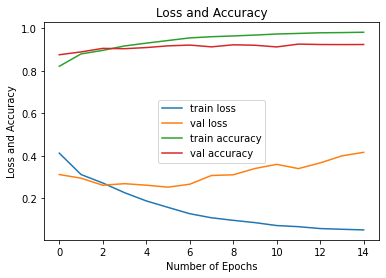

In [86]:
# Plot loss and accuracy
epoch_range = np.arange(0, epochs)
plt.figure()
plt.plot(epoch_range, gender.history['loss'], label='train loss')
plt.plot(epoch_range, gender.history['val_loss'], label='val loss')
plt.plot(epoch_range, gender.history['accuracy'], label='train accuracy')
plt.plot(epoch_range, gender.history['val_accuracy'], label='val accuracy')
plt.title('Loss and Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss and Accuracy')
plt.legend()
plt.show()

In [0]:
# Train neural network to recognize whether male or female

# If female then choose female GAN

# If male then choose male GAN

# Will need to create / train female and male GANs